In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from collections import Counter

from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from hyperopt import STATUS_OK,Trials, fmin, hp, tpe


In [206]:
red_train = pd.read_csv("data/red_wine_train.csv",index_col=0)
red_test = pd.read_csv("data/red_wine_test.csv",index_col=0)

In [207]:
red_train.describe()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality,alcohol_higher,va_high
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.282877,0.531235,0.266059,0.087127,46.464816,0.996715,0.656904,10.421345,5.637217,0.158718,0.354183
std,1.717760,0.176222,0.193606,0.047654,32.173470,0.001916,0.166621,1.084178,0.808633,0.365556,0.478452
min,4.900000,0.120000,0.000000,0.012000,6.000000,0.990070,0.330000,8.400000,3.000000,0.000000,0.000000
25%,7.100000,0.400000,0.090000,0.070000,23.000000,0.995545,0.550000,9.500000,5.000000,0.000000,0.000000
50%,7.900000,0.520000,0.250000,0.079000,38.000000,0.996700,0.620000,10.200000,6.000000,0.000000,0.000000
75%,9.100000,0.640000,0.420000,0.090000,62.000000,0.997800,0.730000,11.100000,6.000000,0.000000,1.000000
max,15.900000,1.580000,1.000000,0.611000,278.000000,1.003690,2.000000,14.900000,8.000000,1.000000,1.000000


First Attempt: outlier removal, and dropping fixed acidity and chlordies, and the two binary variables (no binning)

In [208]:
#dropping binary values that were created just 
red_train = red_train.drop(["alcohol_higher", "va_high"], axis=1)
red_test= red_test.drop(["alcohol_higher", "va_high"], axis=1)

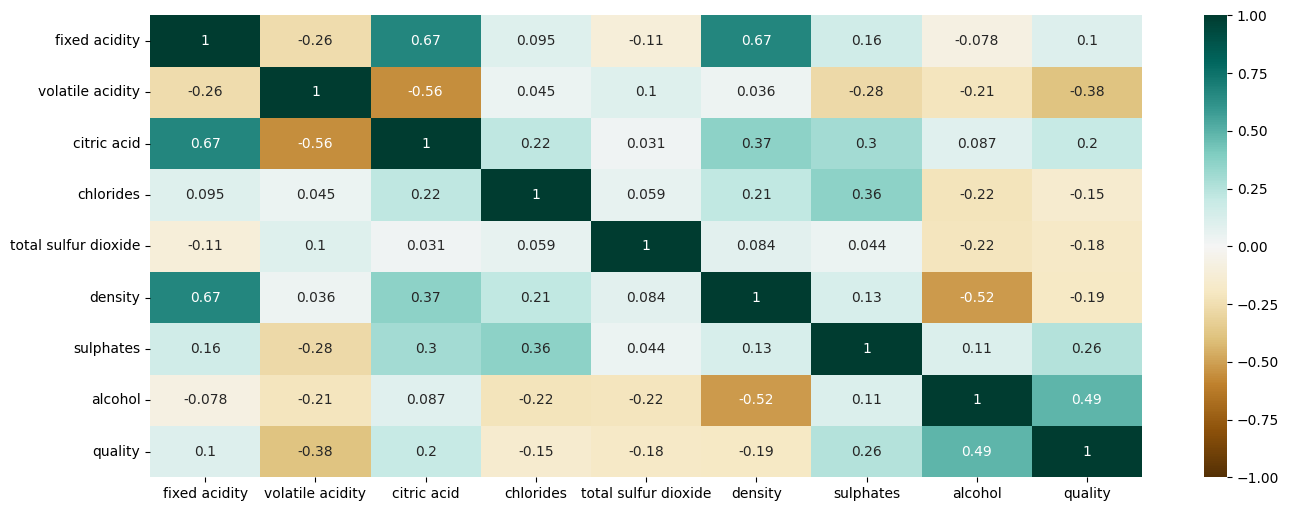

In [209]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(red_train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

---
Preprocessing

For decision trees, there typically no reason to do much when it comes to altering the data. Decision trees do not have much problems with scaled, normalized, and other types continous data is not a big deal (especially with XGB). If we had categorical data, this would be different, espcially if we had to data cleanup, but other than outliers there is not much that can more be done that what is given.

In [221]:
def remove_outliers(df: pd.DataFrame, n :float, columns):
    #this is the Tukey ruel which gets the values that exists outside of the outer fence of a histogram of a particular attribute col
    #This is valuable if outliers effect the data alot (typically regression), in classification this might be different
    #From EDA it seems that we should not remove outliers as they can help point to certain low appearing classes
    total_outliers = []

    for col in columns:

        #generating the quantile ranges that will be used to determine outliers
        q1 = df[col].quantile(.25)
        q3 = df[col].quantile(.75)

        iqr = q3 - q1
        outer_fence = iqr * 1.5

        outliers = df[(df[col] < q1 - outer_fence) | (df[col] > q3 + outer_fence)].index

        total_outliers.extend(outliers)

    #select the indexes (tuples) that have more than n attributes that are outliers (can scale)
    #creates an object that has keys (index), with values (amount of apperences, which is at least one)
    outliers = Counter(total_outliers)

    #iterates over all items and reutrns the
    items_greater =[]
    for i in outliers.items():
        if(i[1] >= n):
            items_greater.append(i[0])

    return items_greater


In [228]:
#chose two as during Eda it seemed that individually there was not much outliers and there were alot of important ones (our negative class 1)
print("old len: " + str(len(red_train)))
outliers = remove_outliers(red_train, 2 , red_train.columns[:-1])
#print("new len: " + str(len(red_train.drop(outliers, axis = 0).reset_index(drop=True))))


old len: 1279
205
601
264
328
363
680
394
440
611
979
374
364
435
580
652
814
581
402
559
294
557
603
339
338
596
564
446
509
391
510
243
442
381
470
599
516
984
340
538
366
555
544
811
433
672
724
700
690
1261
1467
1012
94
126
199
553
38
705
1299
151
210
482
695
517
1474
1423
1193
1021
666
618
1109
326
1374
1191
1220
1436
1252
566
688
408
258
368
512
335
1476
730
1051
754
1372
483
1571
281
291
567
808
169
614
106
81
1165
240
624
692
303
625
181
1558
882
1490
689
549
400
42
837
796
1358
780
1146
1258
447
916
14
396
832
958
777
1434
833
1435
568
451
1014
1259
1570
330
910
125
1260
147
1020
776
109
226
91
684
1401
694
651
415
1561
1079
772
130
145
190
157
791
155
1131
522
163
189
636
354
852
1493
1496
215
591
201
188
1400
1559
723
1560
219
192
463
86
561
637
164
1269
1270
1114
1018
142
821
1475
1228
588
1126
1017
324
480
889
608
1477
144
999
325
503
43
376
369
1289
477
79
161
1158
1367
372
1408
639
1288
506
467
1132


overall outliers are neglible

---
Model Testing

In [213]:
X_train = red_train.drop("quality" , axis=1)
y_train = red_train["quality"]
X_test = red_test.drop("quality" , axis=1).copy()
y_test = red_test["quality"]

In [214]:
#xgb expects only what is present, not the actual scale of the data relative to quality (1-10)
#therefore, we have to map to values 0-5 for the scale 
y_train = y_train.map({3: 0, 4: 1, 5:2, 6:3, 7:4, 8:5})
y_test = y_test.map({3: 0, 4: 1, 5:2, 6:3, 7:4, 8:5})

Hyperopt

    -- uses bayesian optimization to find the best parameter for machine learning algorithm, by using probablistic search of the hyperparamters supplied
       Compared to exahustive search it is much faster and its performance is only a bit lower

    How to implement:
        1. intitalise the domain space (same as a grid search)
        2. define the objective function  that we want to minimze (error rate) of the model that we are testing (XGBoost decision trees in this case)
        3. Optimize alogirhtm choice (the method used to construct the surrogate objective function)
        4. Results, the score or the value pairs that the algorithm uses to build the model

Below the hyperopt stuff but I do not think that I am going to include it in final report. Just skip...

In [215]:
# space = {"max_depth":hp.quniform("max_depth",3,18,1), #the max dept with integer values between 3 and 18
#          "gamma" : hp.uniform('gamma',1,9), #the gamma values with values ranging from 1 to 9 continous
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1), #ratio of columns to use to build tree (stocatic)
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1), #tuning the cv for a particular tree 
#         'n_estimators': 180,
#         'seed': 0
#     }


# def ojective(space:dict):
#         #creating a classifer with the opametrs pulled from the space that has been already been listed. 
#         #Most explanation is above
#         clf=XGBClassifier(
#                 n_estimators =space['n_estimators'],
#                 max_depth = int(space['max_depth']),
#                 gamma = space['gamma'],
#                 min_child_weight=int(space['min_child_weight']),
#                 colsample_bytree=int(space['colsample_bytree']),
#                 objective="multi:softprob", #type of objective function that is used, you have to use softprob for multilabel classification ifor auc
#                 early_stopping_rounds=10, #sets the early stopping rounds if the loss of the gradient boosting of trees is not great enough (need eval_set)
#                 eval_metric="auc") #the measure to determine within the gradient boosting that is trying to

#         #evalutation train set and test set for doing a fit, efficivly measuring against the test like a normal accuracy measure would
#         evaluation = [( X_train, y_train), ( X_test, y_test)]

#         clf.fit(X_train,
#                 y_train,
#                 eval_set=evaluation, #passed in for the set
#                 verbose=False)
        
#         # make a prediction
#         y_pred = clf.predict(X_test)
        
#         accuracy = f1_score(y_test,y_pred,average="weighted",zero_division=1)
#         print("SCORE:" + str(accuracy))
#         return {'loss' : -accuracy, "status" : STATUS_OK}

#trials = Trials()


# best_hyperparams = fmin(fn = ojective,
#                         space = space,
#                         algo = tpe.suggest,
#                         max_evals = 50,
#                         trials = trials)

Available optimizaiton algorithms: (oudated)

    -- hp.choice(label,options) : returns a choice of one of the options

    -- hp.randint(label,upper) : returns a random integer better range of 0 --> upper

    -- hp.uniform(label,low, high) : returns a value uniformly between the low and high

    -- hp.uniform(label,low,high,q) : returns a value round to (uniforn(low,high)/q) , and returns an integer

    -- hp.normal(label,mean,std) : returns a real value that is normally distributed with mean and standard deviation


Trials:

-- an object that contains or stores all the relevent information such as a hyperparameter. The loss functions for each type of parameter is stored
     here. Whenever doing iterations of training with current hyperparameters.

-- fmin is an optimization function that minimizes the loss function for each paramter inside of space.

-- algo: The type of the algorithm for finding best hyperparamter. Tpe is a type of decision tree, so effectively we are using a decision tree to 
            do the hyperparamter choosing.
            
-- max evals: the amount of iterations that we choose to run through
     

Hyper parameters:

    Booster: choose the type of booster to use (we will use tree in this case)
        -- 3 options 
        tree( gbtree,dart)
        linear(gblinear)

    Booster Parameters: only the tree booster ones, only listing the ones usuful to mulitlable imbalanced data (trees for the win)

        -- eta: the learning rat for Gradient boosting, and its range typically is 0.01 - 0.2
        -- gamma: how the node is split in a tree, the larger the more conservative a tree is, range(0 --> infinity)
        -- max_depth: maximum depth of a tree typical values are (3-10), should use cv
        -- min_child_weight: tune using cv but range is 0-->infinite
        -- subsample: fraction of observations to be samples for tree, lower values more conservative, typical values (0,1)
        -- colsample_bytree: ratio of columns when construction each tree
        -- colsample_bylevel: ratio of columns at each level of the tree
        -- tree method: constuction algorithm used in model (multiple choices)
        -- max_leaves: is maximum number of nodes to be added

        Others
        -- alpha : used for lasso regression, increasing makes the model more conservative
        -- lambda : used for ridge regression, increasing makes the model more conservative

    Learning Task: parameters used to define the optimization objective for learning 
        
        --objective: should use multi:softprob or multi: softmax
        --eval metric: should use auc, or merror

In [216]:
space = {'max_depth': [3, 6, 10, 15, 20],
         'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
         'subsample': np.arange(0.5, 1.0, 0.1),
         'gamma' : np.arange(1,9,1),
         'colsample_bytree': np.arange(0.5, 1.0, 0.1),
         'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
         'min_child_weight' : np.arange(1, 10, 1),
         'n_estimators': [100,180, 250, 500, 750],
        }

In [217]:
#making the base model 
#multi prob is a vector, containing all the classes a
model = XGBClassifier(objective="multi:softprob",eval_metric="auc",)
clf = RandomizedSearchCV(estimator=model,
                         param_distributions=space, #assigning space
                         scoring="f1_weighted", #eval metric for the hyperparms, weighted treats the classes as imbalanced
                         n_iter=25, #amount of iterations per cv (random combinations)
                         n_jobs=4, #amount of parralel processes to run
                         random_state=1)

clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=Non...
                   param_distributions={'colsample_bylevel': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'gamma': array([1, 2, 3, 4, 5, 6, 7, 8]),
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4],
                                        'max_depth': [3, 6, 10, 15, 20],
                                        'min_child_weight': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': [100, 180, 250, 500,
                                                         750],
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   random_state=1, scoring='f1_weighted')

In [218]:
best_hyperparams = clf.best_params_
best_hyperparams

{'subsample': 0.8999999999999999,
 'n_estimators': 750,
 'min_child_weight': 9,
 'max_depth': 15,
 'learning_rate': 0.1,
 'gamma': 2,
 'colsample_bytree': 0.8999999999999999,
 'colsample_bylevel': 0.6}

In [219]:
accuracy_f1 = []
recall = [] 
precision = []
accuracy = []
for i in range(0,5):
    #creating model with best hyperparameters
    clf=XGBClassifier(
        n_estimators = best_hyperparams['n_estimators'],
        max_depth = int(best_hyperparams['max_depth']),
        learning_rate = best_hyperparams['learning_rate'],
        gamma = best_hyperparams['gamma'],
        min_child_weight=int(best_hyperparams['min_child_weight']),
        colsample_bytree=int(best_hyperparams['colsample_bytree']),
        colsample_bylevel=best_hyperparams['colsample_bylevel'],
        objective="multi:softprob", #type of objective function that is used, you have to use softprob for multilabel classification ifor auc
        eval_metric="auc", #the measure to determine within the gradient boosting that is trying to
        seed=i)
    
    clf.fit(X_train,y_train)

    y_pred = clf.predict(X_test)

    #appending the scores from the particular rune to the list
    accuracy_f1.append(f1_score(y_test,y_pred,average="weighted",zero_division=1))
    recall.append(recall_score(y_test,y_pred,average="weighted",zero_division=1))
    precision.append(precision_score(y_test, y_pred,average="weighted",zero_division=1))
    accuracy.append(accuracy_score(y_test,y_pred))

In [220]:
average_f1 = np.mean(accuracy_f1)
average_recall = np.mean(recall)
average_precision = np.mean(precision)
average_accuracy = np.mean(accuracy)
print("Average F1: " + str(average_f1))
print("Average Recall: " + str(average_recall))
print("Average Precision: " + str(average_precision))
print("Average Accuracy: " + str(average_accuracy))

Average F1: 0.5943817969672713
Average Recall: 0.62375
Average Precision: 0.653822962237242
Average Accuracy: 0.62375
